Importing Libraries

In [22]:
import numpy as np
import pandas as pd
from utils import *
import warnings
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np
from utils import calculate_aic_bic, calculate_adjusted_r2, calculate_aic_bic
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import TimeSeriesSplit

warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
'''
Load the data and split it into train and test
'''
data = pd.read_csv('Data/data_with_lags_feature_selected.csv', index_col = 0, parse_dates=True)
data.head()

test_data = data.iloc[-int(len(data) * 0.1):]
train_data = data.iloc[:-int(len(data) * 0.1)]

test_X = test_data.iloc[:,1:]
test_y = test_data.iloc[:,0:1]

train_X = train_data.iloc[:,1:]
train_y = train_data.iloc[:,0:1]

1 - Linear Regression

In [24]:
'''
Run the linear regression model
First we fit the model on the train data and then predict the test data
'''
def evaluate_linear_regression(X_train, y_train, X_val, y_val):
    # Initialize the model
    model = LinearRegression()
    
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X = pd.DataFrame(scaler_X.fit_transform(X_train), columns=X_train.columns)
    y = pd.DataFrame(scaler_y.fit_transform(y_train .values.reshape(-1, 1)), columns=['Realized Volatility'])

    # Fit the model
    model.fit(X, y)
    
    print('Model coefficients are: \n',model.coef_)
    
    X_val = scaler_X.transform(X_val)
    # Predict the validation set results
    y_pred = model.predict(X_val)
    
    y_pred = scaler_y.inverse_transform(y_pred)
    y_pred = pd.DataFrame(y_pred, columns=['Realized Volatility'], index = y_val.index)
    # Calculate the metrics
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    mape = mean_absolute_percentage_error(y_val, y_pred)
    cp = calculate_cp(y_val.values, y_pred.values, train_X.shape[1], train_X.shape[0])
    adjusted_r2 = calculate_adjusted_r2(y_val.values, y_pred.values, train_X.shape[1], train_X.shape[0])
    aic, bic = calculate_aic_bic(y_val.values, y_pred.values, train_X.shape[1], train_X.shape[0])

    print(f"The scores on the test set are: \n MSE: {mse} \n, RMSE: {rmse}\n, MAE: {mae}\n, R^2: {r2}\n, Adjusted R^2: {adjusted_r2}\n, C_p: {cp}\n, AIC: {aic}\n, BIC: {bic}\n, MAPE: {mape}\n")

    return y_pred


y_pred = evaluate_linear_regression(train_X, train_y, test_X, test_y)

Model coefficients are: 
 [[ 0.2442348   0.24048829 -0.04534227  0.2470032   0.00296758  0.06085527
   0.06636668 -0.07984136  0.09777456]]
The scores on the test set are: 
 MSE: 5.218569206474077e-06 
, RMSE: 0.0022844187896430192
, MAE: 0.0016386439562642624
, R^2: -0.08011916146505493
, Adjusted R^2: -0.0859436506521043
, C_p: 5.843491831195168e-07
, AIC: -632.7648008690076
, BIC: -24049.473305453528
, MAPE: 0.2630073225989338



In [25]:
y_pred.rename(columns = {'Realized Volatility': 'Predicted Volatility'}, inplace = True)
results_regression = pd.concat([test_y, y_pred], axis = 1)
results_regression.head()

,Realized Volatility,Predicted Volatility
2023-04-05,0.005790,0.006732
2023-04-06,0.005496,0.007163
2023-04-10,0.008563,0.006977
2023-04-11,0.003862,0.007175
2023-04-12,0.009014,0.006422


<Axes: >

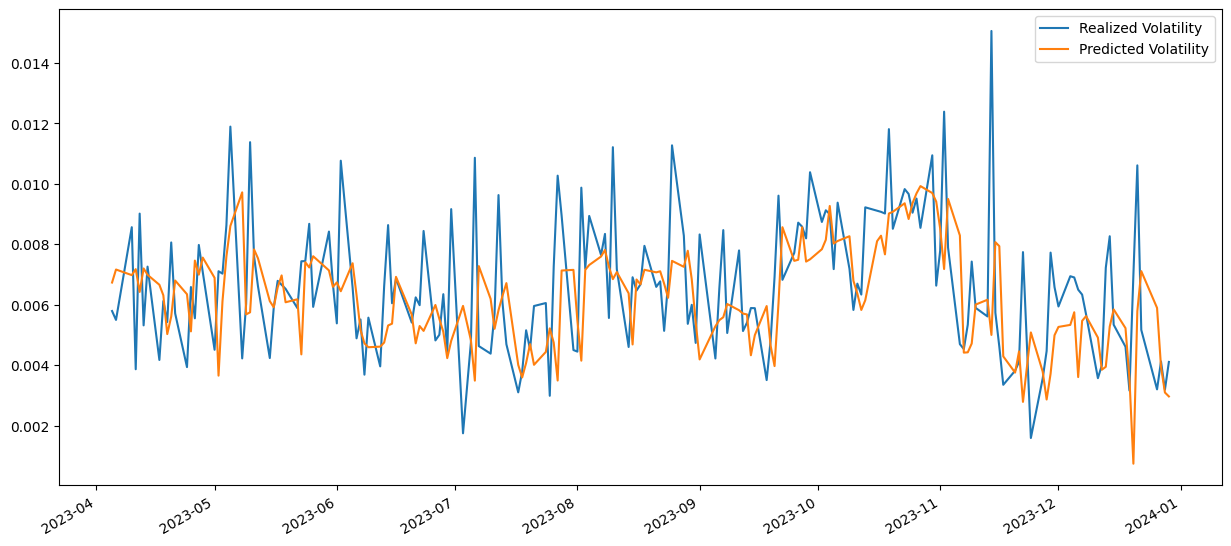

In [26]:
results_regression.plot(figsize = (15, 7))

In [27]:
results_regression.to_csv('Outputs/Models/Linear Regression/linear_regression_results.csv')

2 - Lasso Regression

In [28]:
'''
In order to find the best hyperparameter for the Lasso regression model, we will use the validation set
'''

split = 1 / 9
train_X_lasso, val_X_lasso, train_y_lasso, val_y_lasso = train_X.iloc[:-int(len(train_X) * split)], train_X.iloc[-int(len(train_X) * split):], train_y.iloc[:-int(len(train_y) * split)], train_y.iloc[-int(len(train_y) * split):]

In [29]:
'''
Function for finding the best model with Lasso or Ridge regression using times series cross validation
'''

def evaluate_regularized_regression_ts_cv(X, y, hyperparameters, model_type="Lasso", n_splits=5):
    best_score = np.inf
    best_pred = None
    best_model = None

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = pd.DataFrame(scaler_X.fit_transform(X), columns=X.columns)
    y_scaled = pd.DataFrame(scaler_y.fit_transform(y.values.reshape(-1, 1)), columns=['Realized Volatility'])

    tscv = TimeSeriesSplit(n_splits=n_splits)

    for alpha in hyperparameters['alpha']:
        cv_scores = []
        for train_index, val_index in tscv.split(X_scaled):
            X_train, X_val = X_scaled.iloc[train_index], X_scaled.iloc[val_index]
            y_train, y_val = y_scaled.iloc[train_index], y_scaled.iloc[val_index]

            if model_type == "Lasso":
                model = Lasso(alpha=alpha, max_iter=10000, fit_intercept=True)
            elif model_type == "Ridge":
                model = Ridge(alpha=alpha, max_iter=10000, fit_intercept=True)

            # Fit the model
            model.fit(X_train, y_train)

            # Predict the validation set results
            y_pred = model.predict(X_val)
            y_pred = y_pred.reshape(-1, 1)
            y_pred = scaler_y.inverse_transform(y_pred)
            y_pred = pd.DataFrame(y_pred, columns=['Realized Volatility'], index=y_val.index)

            # Calculate the metrics
            MAPE = mean_absolute_percentage_error(scaler_y.inverse_transform(y_val), y_pred)
            cv_scores.append(MAPE)

        mean_cv_score = np.mean(cv_scores)
        if mean_cv_score < best_score:
            best_score = mean_cv_score
            best_model = model

        print(f"Results for alpha = {alpha}: MAPE = {mean_cv_score}")

    print(f"Best alpha for MAPE: {best_model.alpha} which gives MAPE: {best_score}")
    return best_model


In [30]:
'''
Function for finding the scores of a specific model with Lasso or Ridge regression
'''
def evaluate_regularized_regression(X_train, y_train, X_val, y_val, alpha,  model_type = "Lasso"):
    
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X = pd.DataFrame(scaler_X.fit_transform(X_train), columns=X_train.columns)
    y = pd.DataFrame(scaler_y.fit_transform(y_train .values.reshape(-1, 1)), columns=['Realized Volatility'])
    
    X_val = scaler_X.transform(X_val)
    
    if model_type == "Lasso":
        model = Lasso(alpha=alpha, max_iter=10000, fit_intercept=True)
    elif model_type == "Ridge":
        model = Ridge(alpha=alpha, max_iter=10000, fit_intercept=True)
        
        # Fit the model
    model.fit(X, y)

    # Predict the validation set results
    y_pred = model.predict(X_val)
    y_pred = y_pred.reshape(-1, 1)
    y_pred = scaler_y.inverse_transform(y_pred)
    y_pred = pd.DataFrame(y_pred, columns=['Realized Volatility'], index = y_val.index)
    
    # Calculate the metrics
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    MAPE = mean_absolute_percentage_error(y_val, y_pred)
    cp = calculate_cp(y_val.values, y_pred.values, X_train.shape[1], X_train.shape[0])
    adjusted_r2 = calculate_adjusted_r2(y_val.values, y_pred.values, X_train.shape[1], X_train.shape[0])
    aic, bic = calculate_aic_bic(y_val.values, y_pred.values, X_train.shape[1], X_train.shape[0])
    

    print(f"Results for alpha = {alpha}: \n MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R^2: {r2}, Adjusted R^2: {adjusted_r2}, C_p: {cp}, AIC: {aic}, BIC: {bic}, MAPE: {MAPE}")

    return y_pred, model


In [31]:
'''
Finding the best hyperparameter for the Lasso regression model
'''
hyperparameters = {'alpha': [0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
best_model = evaluate_regularized_regression_ts_cv(train_X, train_y, hyperparameters, model_type = "Lasso", n_splits=5)

Results for alpha = 1e-05: MAPE = 0.31336856266842894
Results for alpha = 0.0001: MAPE = 0.3133675182579689
Results for alpha = 0.001: MAPE = 0.37658067011294744
Results for alpha = 0.01: MAPE = 0.5068812166725178
Results for alpha = 0.1: MAPE = 0.5068812166725178
Results for alpha = 1: MAPE = 0.5068812166725178
Results for alpha = 10: MAPE = 0.5068812166725178
Results for alpha = 100: MAPE = 0.5068812166725178
Results for alpha = 1000: MAPE = 0.5068812166725178
Best alpha for MAPE: 0.0001 which gives MAPE: 0.3133675182579689


In [32]:
y_pred, model = evaluate_regularized_regression(train_X, train_y, test_X, test_y, alpha = best_model.alpha, model_type = "Lasso")

Results for alpha = 0.0001: 
 MSE: 4.917542684908792e-06, RMSE: 0.0022175533104998382, MAE: 0.0015915626499051036, R^2: -0.01781386260105422, Adjusted R^2: -0.023302373543780064, C_p: 5.506417443533968e-07, AIC: -643.8158633655544, BIC: -24149.229939494933, MAPE: 0.25619951575648775


In [33]:
'''
Printing the coefficients of the best model to see which columns are selected by Lasso
'''
for coeff in zip(train_X.columns, model.coef_):
    print("Feature: {}, Coefficient: {}".format(coeff[0], coeff[1]))

Feature: Realized Volatility_lag_1, Coefficient: 0.23211334974342893
Feature: Realized Volatility_lag_2, Coefficient: 0.23651631200743561
Feature: US Policy Index_lag_1, Coefficient: -0.028214562678952428
Feature: VIX_lag_1, Coefficient: 0.24381467382452657
Feature: Volume_lag_2, Coefficient: 0.0
Feature: term_spread_ret_lag_2, Coefficient: 0.010872417022993979
Feature: 13w TB_ret_lag_1, Coefficient: 0.0
Feature: 13w TB_ret_lag_2, Coefficient: -0.0
Feature: Abs Return_lag_1, Coefficient: 0.08605127986913319


In [34]:
y_pred.rename(columns = {'Realized Volatility': 'Predicted Volatility'}, inplace = True)
results_lasso = pd.concat([test_y, y_pred], axis = 1)
results_lasso.head()

,Realized Volatility,Predicted Volatility
2023-04-05,0.005790,0.006712
2023-04-06,0.005496,0.006972
2023-04-10,0.008563,0.006839
2023-04-11,0.003862,0.007209
2023-04-12,0.009014,0.006683


<Axes: >

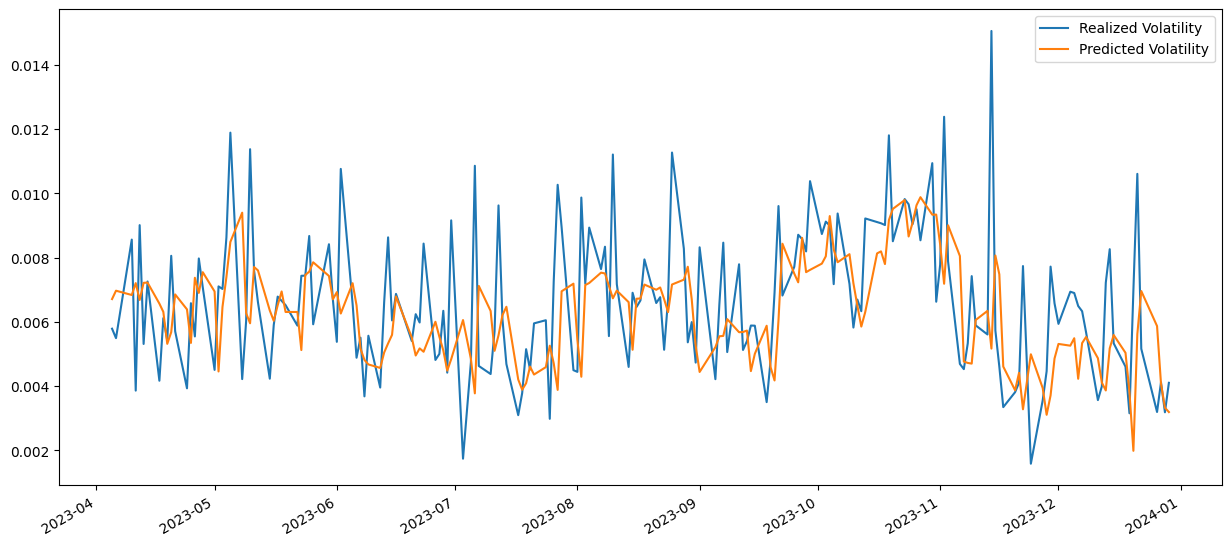

In [35]:
results_lasso.plot(figsize = (15, 7))

In [36]:
results_lasso.to_csv('Outputs/Models/Lasso/Lasso_results.csv')

3 - Ridge Regression

In [37]:
hyperparameters = {'alpha': [0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
best_model = evaluate_regularized_regression_ts_cv(train_X, train_y, hyperparameters, model_type = "Ridge", n_splits=5)

Results for alpha = 1e-05: MAPE = 0.3198319581033135
Results for alpha = 0.0001: MAPE = 0.31981138951625165
Results for alpha = 0.001: MAPE = 0.3196089963869292
Results for alpha = 0.01: MAPE = 0.3179817272898545
Results for alpha = 0.1: MAPE = 0.3130018654989811
Results for alpha = 1: MAPE = 0.3284376715248964
Results for alpha = 10: MAPE = 0.4025667763958822
Results for alpha = 100: MAPE = 0.4721379090882962
Results for alpha = 1000: MAPE = 0.5017297394628708
Best alpha for MAPE: 0.1 which gives MAPE: 0.3130018654989811


In [38]:
for coeff in zip(train_X.columns, best_model.coef_[0]):
    print("Feature: {}, Coefficient: {}".format(coeff[0], coeff[1]))

Feature: Realized Volatility_lag_1, Coefficient: 0.2466096329214216
Feature: Realized Volatility_lag_2, Coefficient: 0.25661611801984807
Feature: US Policy Index_lag_1, Coefficient: -0.04821015027700784
Feature: VIX_lag_1, Coefficient: 0.2318182260101695
Feature: Volume_lag_2, Coefficient: 0.00930688405635605
Feature: term_spread_ret_lag_2, Coefficient: 0.05257198759308359
Feature: 13w TB_ret_lag_1, Coefficient: 0.05716482426113346
Feature: 13w TB_ret_lag_2, Coefficient: -0.07398620343694541
Feature: Abs Return_lag_1, Coefficient: 0.10698697988093572


In [39]:
y_pred, model = evaluate_regularized_regression(train_X, train_y, test_X, test_y,alpha=best_model.alpha, model_type = "Ridge")


Results for alpha = 0.1: 
 MSE: 5.192435780248104e-06, RMSE: 0.002278691681699853, MAE: 0.0016352178289893312, R^2: -0.07471016652705753, Adjusted R^2: -0.08050548797627477, C_p: 5.814228932375475e-07, AIC: -633.6985872793606, BIC: -24057.90248493193, MAPE: 0.26253666375435497


In [40]:
y_pred.rename(columns = {'Realized Volatility': 'Predicted Volatility'}, inplace = True)
results_ridge = pd.concat([test_y, y_pred], axis = 1)
results_ridge.head()

,Realized Volatility,Predicted Volatility
2023-04-05,0.005790,0.006748
2023-04-06,0.005496,0.007166
2023-04-10,0.008563,0.006975
2023-04-11,0.003862,0.007152
2023-04-12,0.009014,0.006418


<Axes: >

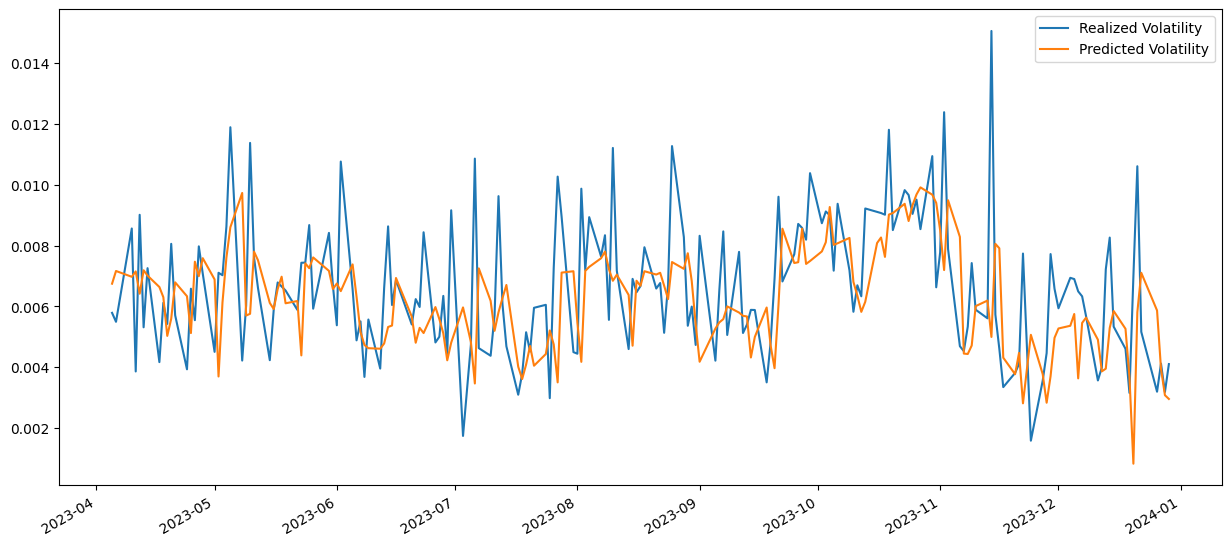

In [41]:
results_ridge.plot(figsize = (15, 7))

In [42]:
results_ridge.to_csv('Outputs/Models/Ridge/Ridge_results.csv')